In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torchvision import datasets, transforms


In [2]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        self.mean_layer = nn.Linear(64, latent_dim)
        self.var_layer = nn.Linear(64, latent_dim)
        

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mean = self.mean_layer(x)
        log_var = self.var_layer(x)
        return mean, log_var

    def reparameterise(self, mean, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mean + eps*std

    def decode(self,x):
        return self.decoder(x)

    def forward(self,x):
        mean, log_var = self.encode(x)
        z = self.reparameterise(mean, log_var)
        decoded = self.decode(z)
        return decoded, mean, log_var

In [3]:
def visualize_latent_space(vae, test_loader, title):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae = vae.to(device)
    vae.eval()
    mu_list = []
    labels_list = []
    
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            data = data.view(-1, 784)
            mu, _ = vae.encode(data)
            mu_list.append(mu.cpu())
            labels_list.append(labels)
            
    mu_all = torch.cat(mu_list, dim=0)
    labels_all = torch.cat(labels_list, dim=0)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(mu_all[:, 0], mu_all[:, 1], c=labels_all, cmap='tab10')
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()
    

In [4]:

def visualize_grid(vae, grid_size=20, range_=3, title="Generated Images"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae = vae.to(device)
    vae.eval()
    x = np.linspace(-range_, range_, grid_size)
    y = np.linspace(-range_, range_, grid_size)
    xx, yy = np.meshgrid(x, y)
    
    grid_points = torch.FloatTensor(np.column_stack([xx.ravel(), yy.ravel()])).to(device)
    
    with torch.no_grad():
        decoded = vae.decode(grid_points)
    
    decoded = decoded.cpu().numpy().reshape(grid_size, grid_size, 28, 28)
    
    plt.figure(figsize=(15, 15))
    for i in range(grid_size):
        for j in range(grid_size):
            plt.subplot(grid_size, grid_size, i * grid_size + j + 1)
            plt.imshow(decoded[i, j], cmap='gray')
            plt.axis('off')
    plt.suptitle(title)
    plt.show()

In [5]:
def train(model, train_loader, epochs, use_rcl, use_kld, loss_func, device, input_dim, learning_rate=1e-3, beta=1.0):
    optimiser = optim.Adam(model.parameters(), lr=learning_rate)
    model.to(device)

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (image, _) in enumerate(train_loader):
            batch_size = image.size(0)
            image = image.to(device)
            image = image.view(-1, input_dim)
            model.train()
            optimiser.zero_grad()
            reconstructed_image, mean, log_var = model(image)

            if loss_func == 'bce':
                recon_loss = F.binary_cross_entropy(reconstructed_image, image, reduction='sum') / batch_size
            else:
                recon_loss = F.mse_loss(reconstructed_image, image, reduction='sum') / batch_size

            kl_loss = (-0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())) / (batch_size * input_dim)

            loss = 0
            if use_rcl:
                loss += recon_loss
            if use_kld:
                loss += beta * kl_loss
                
            loss.backward()
            total_loss += loss.item() * batch_size
            optimiser.step()

        if (epoch+1)%10 == 0:
            print(f'Epoch {epoch+1}, Average loss: {total_loss / len(train_loader.dataset):.4f}')

In [6]:
input_dim = 784
latent_dim = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
epochs = 20

In [7]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 41.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.16MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.5MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.4MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch 10, Average loss: 134.1706
Epoch 20, Average loss: 129.9099


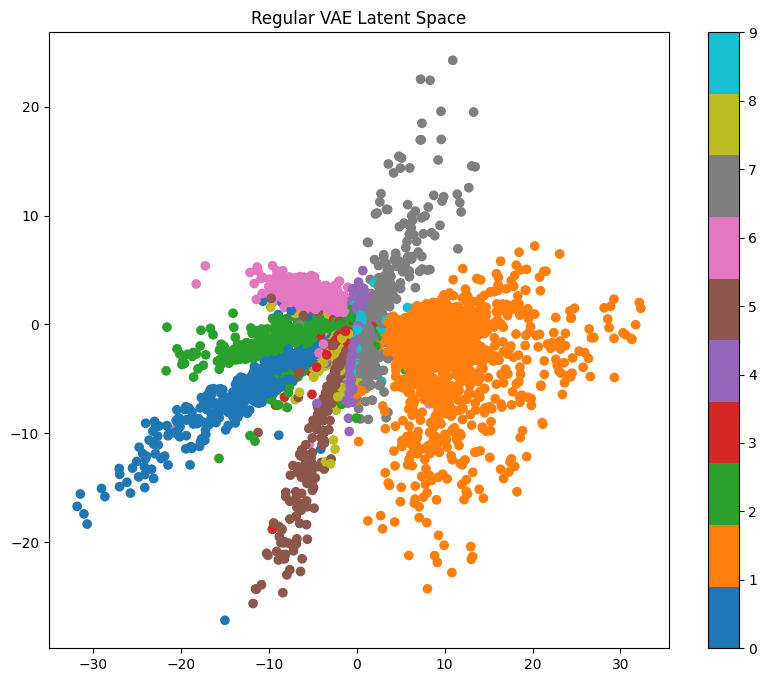

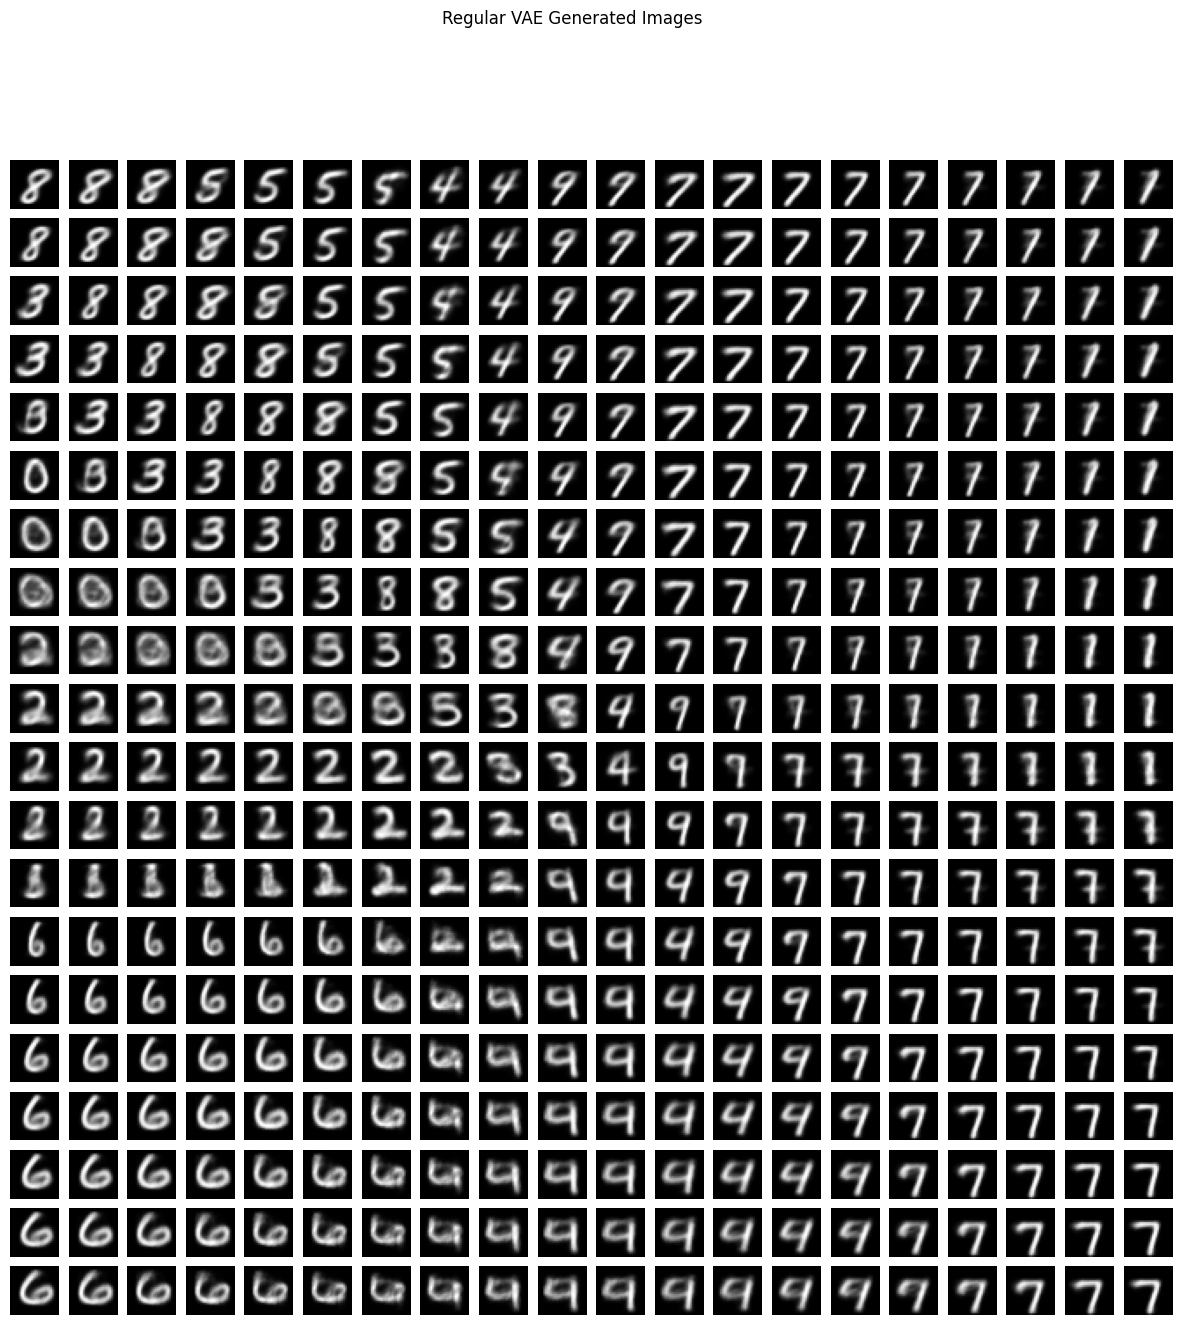

In [8]:
# 1. Regular VAE with BCE loss
vae = VAE(input_dim, latent_dim)
train(model=vae, train_loader=train_loader, epochs=epochs, use_rcl=True, use_kld=True, loss_func='bce', device = device, input_dim=input_dim)
visualize_latent_space(vae, test_loader, "Regular VAE Latent Space")
visualize_grid(vae, title="Regular VAE Generated Images")


Epoch 10, Average loss: 0.0000
Epoch 20, Average loss: 0.0000


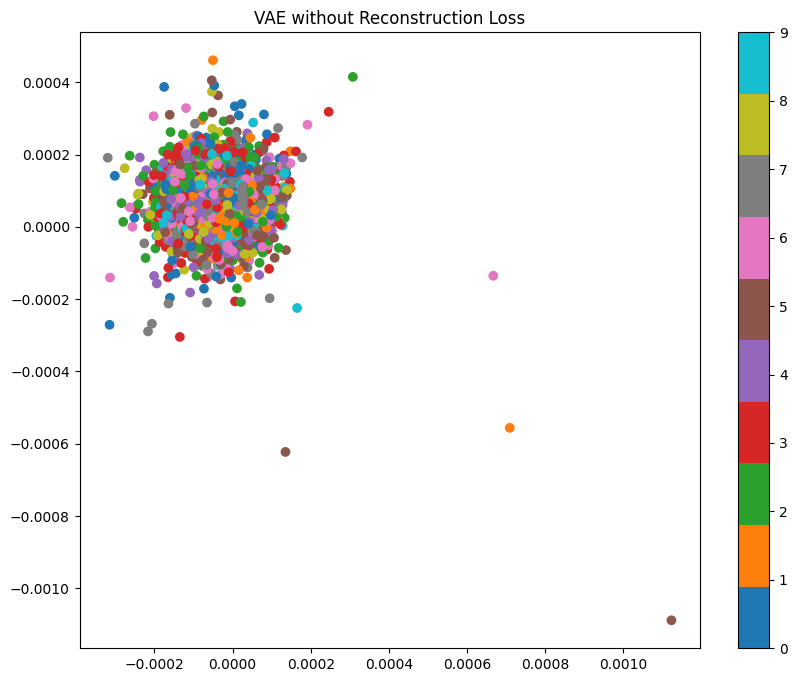

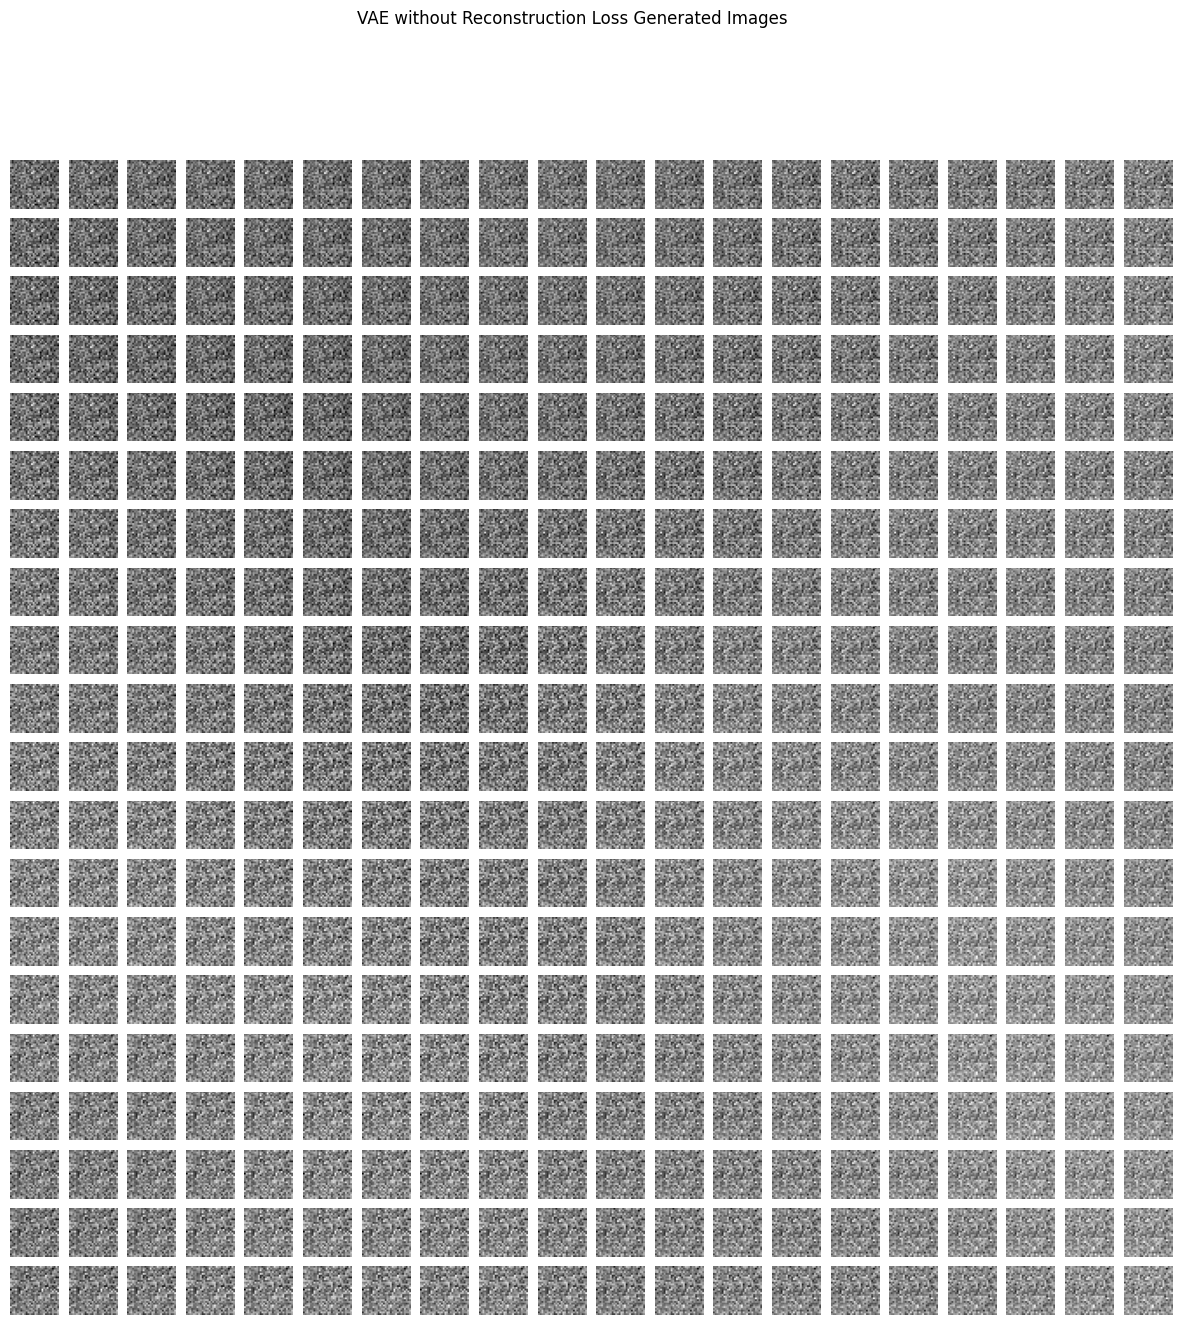

In [9]:
# 2. VAE without reconstruction loss
vae_no_recon = VAE(input_dim, latent_dim)
train(model=vae_no_recon, train_loader=train_loader, epochs=epochs, use_rcl=False, use_kld=True, loss_func='bce', device = device, input_dim=input_dim)
visualize_latent_space(vae_no_recon, test_loader, "VAE without Reconstruction Loss")
visualize_grid(vae_no_recon, title="VAE without Reconstruction Loss Generated Images")

Epoch 10, Average loss: 134.5306
Epoch 20, Average loss: 134.0994


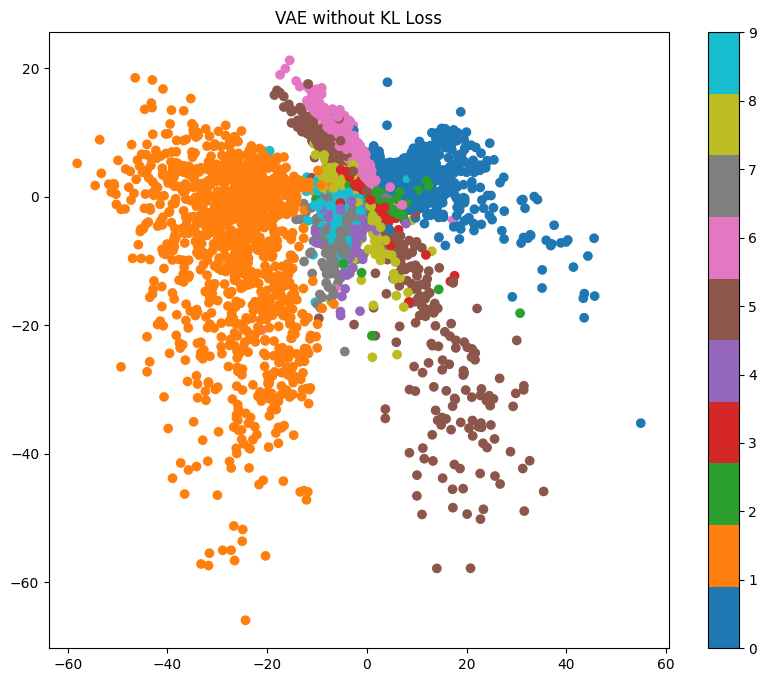

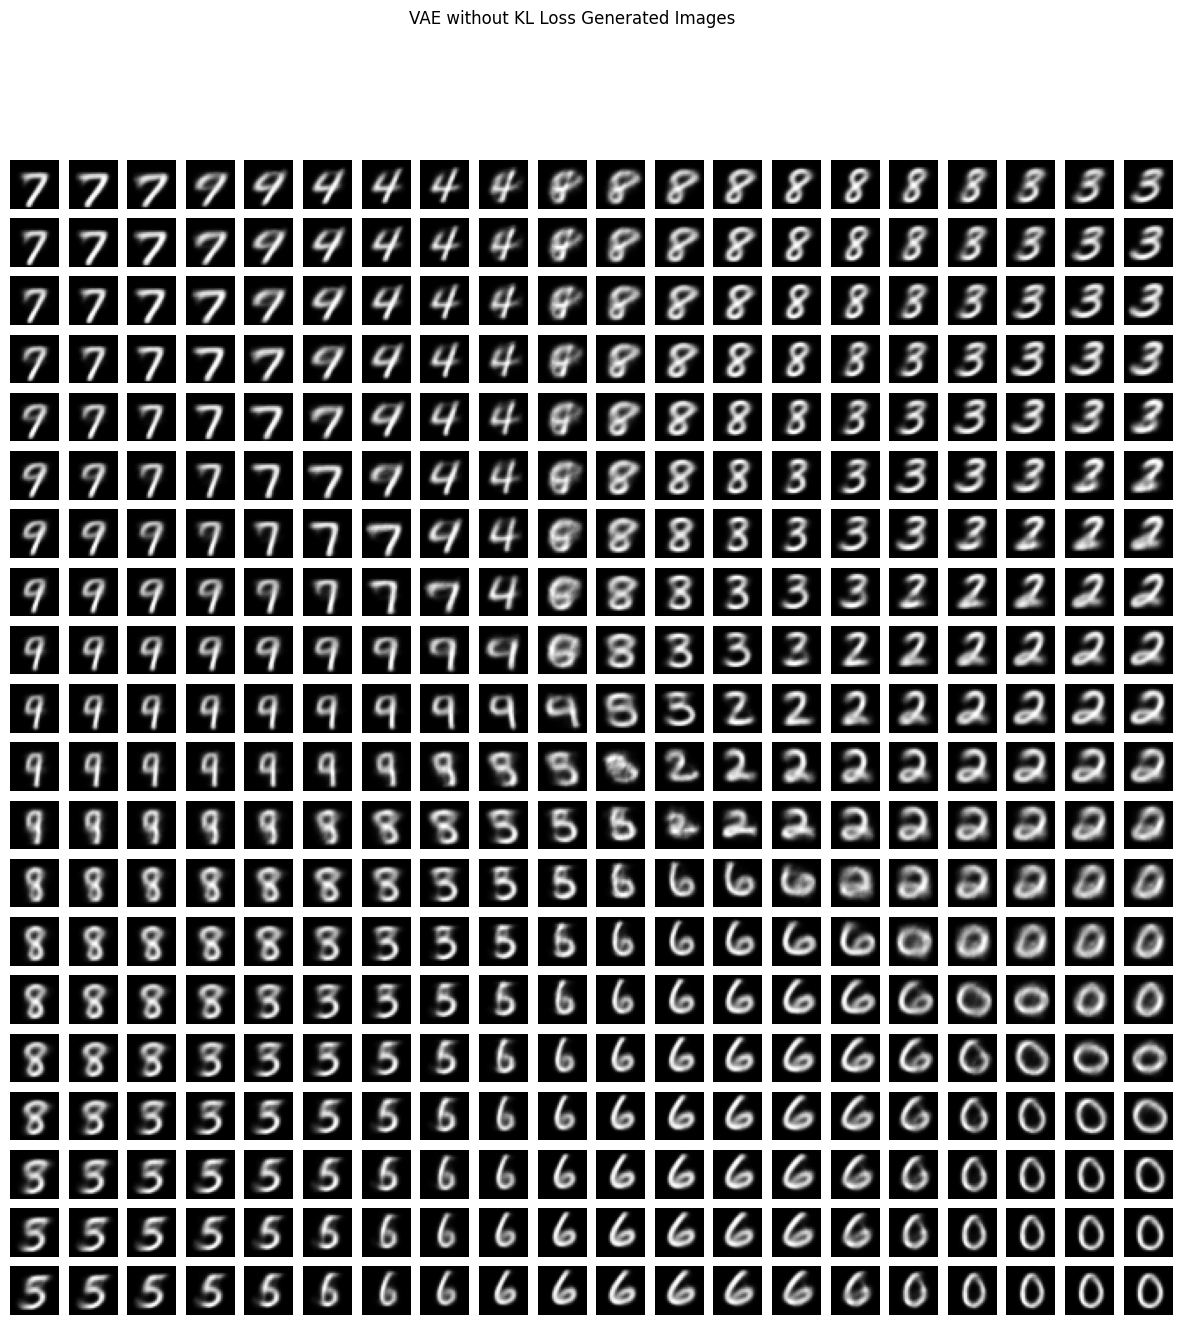

In [10]:
# 3. VAE without KL loss
vae_no_kl = VAE(input_dim, latent_dim)
train(model=vae_no_kl, train_loader=train_loader, epochs=epochs, use_rcl=True, use_kld=False, loss_func='bce', device = device, input_dim=input_dim)
visualize_latent_space(vae_no_kl, test_loader, "VAE without KL Loss")
visualize_grid(vae_no_kl, title="VAE without KL Loss Generated Images")


Epoch 10, Average loss: 28.1883
Epoch 20, Average loss: 27.1119


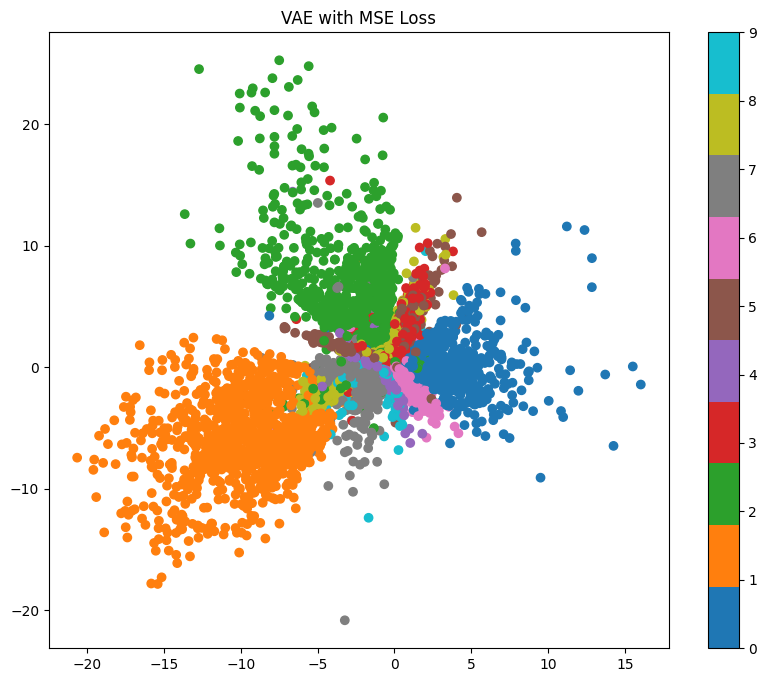

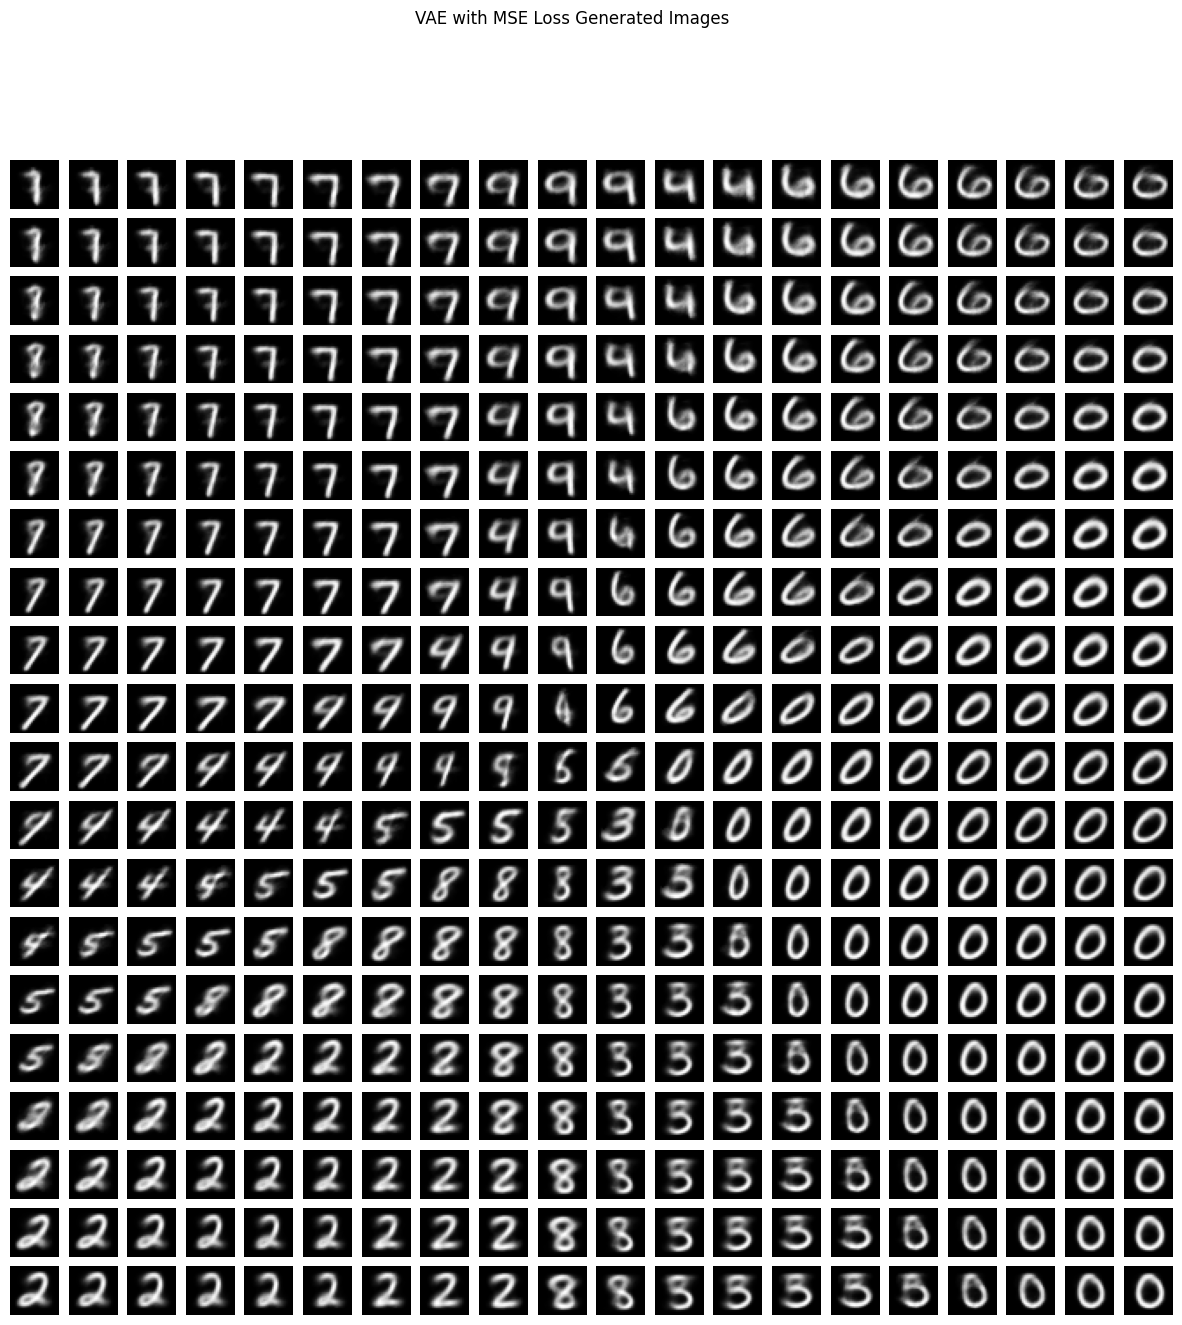

In [11]:
# 4. VAE with MSE loss
vae_mse = VAE(input_dim, latent_dim)
train(model=vae_mse, train_loader=train_loader, epochs=epochs, use_rcl=True, use_kld=True, loss_func='mse', device = device, input_dim=input_dim)
visualize_latent_space(vae_mse, test_loader, "VAE with MSE Loss")
visualize_grid(vae_mse, title="VAE with MSE Loss Generated Images")

# Observations

## Regular VAE (with both BCE reconstruction loss and KL divergence)  
The regular VAE with both losses produces clear, recognizable digits in the generated images. The latent space visualization shows well-separated clusters for different digits, indicating that the model has learned a meaningful representation where similar digits are grouped together. This is the expected behavior as:  

- The **reconstruction loss** ensures the decoder can accurately reproduce the input images.  
- The **KL divergence loss** ensures the latent space is well-structured and follows a Gaussian distribution.  
- Together, they create a balance between **reconstruction quality** and **latent space organization**.  

---

## When the reconstruction loss is removed  
The images produced by the decoder are blurry, and no digits are visible. This severe degradation occurs because:  

- Without reconstruction loss, the model has **no incentive** to accurately reproduce the input images.  
- The KL divergence alone **pushes all encodings** towards a standard normal distribution.  
- The decoder never learns to map latent vectors to meaningful digit images.  
- The latent space likely **collapses** to a standard normal distribution without preserving any meaningful structure from the input data.  

---

## When the KL divergence loss is removed  
The generated images are sharp but lack diversity. This happens because:  

- Without KL divergence, the encoder is not constrained to produce a **continuous latent space**.  
- The model can create **isolated clusters** in the latent space, leading to "memorization" rather than "generalization."  
- The latent space visualization shows **distinct, separated points** rather than a continuous distribution.  
- While individual reconstructions may be **high quality**, the model loses its **generative capabilities**, and interpolation between digits becomes meaningless.  

---

## When using MSE instead of BCE loss  
The generated images appear slightly more blurry compared to BCE loss because:  

- **MSE loss treats all pixels equally**, while BCE is better suited for binary-like pixel values (black and white).  
- **MSE tends to produce averaged/blurry outputs** as it minimizes the squared error.  
- The latent space organization might be similar to the BCE case, but the reconstructions are **less sharp**.  

This shows why **BCE is often preferred** for binary or near-binary image data like MNIST.  
  
